In [353]:
import numpy as np
import pandas as pd
import os
import glob
import json
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import re
import statistics
import math
import seaborn as sns

### Data loading

In [2]:
def Get_Data_From_JSON(json_dict):
    time_stamps = json_dict["Timestamp"]
    all_tools = json_dict["Recordings"]
    ## find drill
    for tool_rec in all_tools:
        if tool_rec["ToolName"] == "Unium_Drill":
            drill_info = tool_rec["Info"]
            drill_translation = tool_rec["Translation"]
            drill_rotation = tool_rec["Rotation"]
    # basic info loading
    drill_df = pd.DataFrame()
    drill_df["ActivityLabel"] = drill_info["ActivityLabel"]
    drill_df["Translation_X"] = drill_translation["X"]
    drill_df["Translation_Y"] = drill_translation["Y"]
    drill_df["Translation_Z"] = drill_translation["Z"]
    drill_df["Rotation_X"] = drill_rotation["X"]
    drill_df["Rotation_Y"] = drill_rotation["Y"]
    drill_df["Rotation_Z"] = drill_rotation["Z"]
    drill_df["Rotation_W"] = drill_rotation["W"]
    drill_df["time_stamps"] = time_stamps
    return drill_df

### Filter the trajectory, outlier removal, and create manual index

In [3]:
# distance helper
def Distance(x1, y1, z1, x2, y2, z2):
    d = 0.0
    d = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    return d

In [4]:
# Change-of-location outlier removal
def Outlier_Removal(cur_df):
    # calculate distances btw points
    distances = []
    distances.append(0.0)
    removal_indices = []
    for i in range(cur_df.shape[0] - 1):
        prev = cur_df.iloc[i]
        cur = cur_df.iloc[i + 1]
        distance = Distance(prev["Translation_X"], prev["Translation_Y"], prev["Translation_Z"], cur["Translation_X"], cur["Translation_Y"], cur["Translation_Z"])
        distances.append(distance)
    print("Before removal, there are: " + str(len(distances)) + " points.")
    mean = statistics.mean(distances)
    std = statistics.stdev(distances)
    threshold = mean + 3 * std
    for i in range(len(distances)):
        if distances[i] > threshold:
            removal_indices.append(i)
    print("Following indices are removed:")
    print (*removal_indices, sep=",")
    removed_df = cur_df.drop(removal_indices)
    return removed_df

In [5]:
# Moving average filtering (compression, smoothing outliers, and filtering at same time)
def Moving_Average_Filtering(cur_df, factor=3):
    window_size = factor**2
    cur_df['average_translation_X'] = cur_df["Translation_X"].rolling(window_size).mean()
    cur_df['average_translation_Y'] = cur_df["Translation_Y"].rolling(window_size).mean()
    cur_df['average_translation_Z'] = cur_df["Translation_Z"].rolling(window_size).mean()

    cur_df['average_rotation_X'] = cur_df["Rotation_X"].rolling(window_size).mean()
    cur_df['average_rotation_Y'] = cur_df["Rotation_Y"].rolling(window_size).mean()
    cur_df['average_rotation_Z'] = cur_df["Rotation_Z"].rolling(window_size).mean()
    cur_df['average_rotation_W'] = cur_df["Rotation_W"].rolling(window_size).mean()

    cur_df.dropna(inplace = True)

    cur_df = cur_df.iloc[::factor, :]
    return cur_df

In [6]:
def Create_Manual_Index(time_stamps):
    manual_index = []
    for i in range(len(time_stamps)):
        manual_index.append(i)
    return manual_index

### Intrinsic features

In [7]:
def get_matrix(translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z, rotation_w):
    T = np.zeros((4, 4), dtype=np.float32)
    T[:-1, 3] = [translation_x, translation_y, translation_z]
    T[0:3, 0:3] = R.from_quat([rotation_x, rotation_y, rotation_z, rotation_w]).as_matrix()
    T[3, 3] = 1
    return T

def get_inverse(T):
    inv = np.zeros(T.shape, dtype=np.float32)
    inv[0:3, 0:3] = T[0:3, 0:3].T
    trans = -T[0:3, 0:3].T @ T[:-1, 3]
    inv[:-1, 3] = trans
    inv[3, 3] = 1
    return inv

def get_intrinsic_distance(translation_x, translation_y, translation_z, rotation_x, rotation_y, rotation_z, rotation_w):
    intrinsics = []
    for i in range(len(translation_x) - 1):
        T_cur = get_matrix(translation_x[i], translation_y[i], translation_z[i], rotation_x[i], rotation_y[i], rotation_z[i],
                          rotation_w[i])
        T_next = get_matrix(translation_x[i + 1], translation_y[i + 1], translation_z[i + 1], 
                            rotation_x[i + 1], rotation_y[i + 1], rotation_z[i + 1], rotation_w[i+1])
        T_delta = get_inverse(T_cur) @ T_next
        quats = R.from_matrix(T_delta[:3, :3]).as_quat()
        intrinsics.append(np.concatenate((T_delta[:-1, 3], quats)))
    return intrinsics

In [8]:
def Construct_Intrinsic_Features(drill_df):
    intrinsics = get_intrinsic_distance(drill_df['Translation_X'].to_list(), drill_df['Translation_Y'].to_list(), 
                                    drill_df['Translation_Z'].to_list(), drill_df['Rotation_X'].to_list(), 
                                    drill_df['Rotation_Y'].to_list(), drill_df['Rotation_Z'].to_list(), drill_df['Rotation_W'].to_list())
    numpy_intrinsics = np.array(intrinsics)
    intrinsic_translation_x = numpy_intrinsics[:,0]
    intrinsic_translation_x = np.insert(intrinsic_translation_x,0,intrinsic_translation_x[0])
    intrinsic_translation_y = numpy_intrinsics[:,1]
    intrinsic_translation_y = np.insert(intrinsic_translation_y,0,intrinsic_translation_y[0])
    intrinsic_translation_z = numpy_intrinsics[:,2]
    intrinsic_translation_z = np.insert(intrinsic_translation_z,0,intrinsic_translation_z[0])
    intrinsic_rotation_x = numpy_intrinsics[:,3]
    intrinsic_rotation_x = np.insert(intrinsic_rotation_x,0,intrinsic_rotation_x[0])
    intrinsic_rotation_y = numpy_intrinsics[:,4]
    intrinsic_rotation_y = np.insert(intrinsic_rotation_y,0,intrinsic_rotation_y[0])
    intrinsic_rotation_z = numpy_intrinsics[:,5]
    intrinsic_rotation_z = np.insert(intrinsic_rotation_z,0,intrinsic_rotation_z[0])
    intrinsic_rotation_w = numpy_intrinsics[:,6]
    intrinsic_rotation_w = np.insert(intrinsic_rotation_w,0,intrinsic_rotation_w[0])

    # scale the intrinsic feature for future analysis

    drill_df["intrinsic_translation_x"] = intrinsic_translation_x * 1000
    drill_df["intrinsic_translation_y"] = intrinsic_translation_y * 1000
    drill_df["intrinsic_translation_z"] = intrinsic_translation_z * 1000

    drill_df["intrinsic_rotation_x"] = intrinsic_rotation_x
    drill_df["intrinsic_rotation_y"] = intrinsic_rotation_y
    drill_df["intrinsic_rotation_z"] = intrinsic_rotation_z
    drill_df["intrinsic_rotation_w"] = intrinsic_rotation_w

#### Event protocal loading and construct key-dictionary pairs

In [9]:
def Extract_Drillin(drill_in_df):
    drill_in_df = drill_in_df[drill_in_df["ActivityLabel"] == 0]
    return drill_in_df

In [10]:
# returns indices of the end of segments
def Find_Segments(df):
    indices = []
    manual_index = df["manual_index"].to_list()
    for i in range(len(manual_index) - 1):
        if not (int(manual_index[i]) + 1 == int(manual_index[i + 1])):
            indices.append(i)
            if len(indices) == 10:
                break
    print("indices found for current file: "+ str(len(indices)))
    return indices

In [11]:
# get three penetration values from the txt file
def Get_Penetration(file_name):
    print("Loading event file: " + file_name)
    penetrations = []
    with open(file_name, 'r') as file:
        text = file.read().replace('\n', '')
        all_indices = [m.end() for m in re.finditer('drillSoftTissuePenetration', text)]
        first_drill_index = all_indices[0] + 2
        second_drill_index = all_indices[1] + 2
        last_drill_index = all_indices[len(all_indices) - 1] + 2

        ## convert to millimeters
        first_penetration = round(float(text[first_drill_index : first_drill_index + 8]) * 1000, 2)
        second_penetration = round(float(text[second_drill_index : second_drill_index + 8]) * 1000, 2)
        last_penetration = round(float(text[last_drill_index : last_drill_index + 8]) * 1000, 2)

        penetrations.extend([first_penetration, second_penetration, last_penetration])
        return penetrations

### All data loading and extracted feature df construction

In [12]:
# Not enabling noise filter here, as MA smoothing will do the job and there's no extreme measurement errors
def Load_All(data_path, storeage_df):
    """Load all data"""
    ### data_path is the path of data from CURRENT directory!
    os_path = os.getcwd()
    json_files = glob.glob(os.path.join(os_path, data_path,"*.json"))
    for file in json_files:
        print("Loading file: " + file)
        with open(file, "rb") as json_file:
            cur_json_dict = json.load(json_file)
            cur_drill_df = Get_Data_From_JSON(cur_json_dict)
            # filter the trajectory here
            cur_manual_index = Create_Manual_Index(cur_drill_df["time_stamps"])
            cur_drill_df["manual_index"] = cur_manual_index
            Construct_Intrinsic_Features(cur_drill_df)
            cur_drill_df = Extract_Drillin(cur_drill_df)
            cur_end_indices = Find_Segments(cur_drill_df)
            # construct segments
            cur_feature_list = []
            first_drill_in_df = cur_drill_df.iloc[:cur_end_indices[0] + 1, :]
            #first_drill_in_df = Outlier_Removal(first_drill_in_df)
            first_drill_in_df = Moving_Average_Filtering(first_drill_in_df, 3)

            second_drill_in_df = cur_drill_df.iloc[cur_end_indices[0] + 1: cur_end_indices[1] + 1, :]
            #second_drill_in_df = Outlier_Removal(second_drill_in_df)
            second_drill_in_df = Moving_Average_Filtering(second_drill_in_df, 3)

            # not using filtering for the third drill here, as the third drill is already short in most cases.
            thrid_drill_in_df = cur_drill_df.iloc[cur_end_indices[2] + 1 :, :]
            #thrid_drill_in_df = Outlier_Removal(thrid_drill_in_df)
            thrid_drill_in_df = Moving_Average_Filtering(thrid_drill_in_df, 2)

            cur_feature_list.extend([first_drill_in_df, second_drill_in_df, thrid_drill_in_df])
            cur_penetrations_in_mm = Get_Penetration(file[:len(file) - 17] + "_EventProtocol.txt")
            # construct key-value pairs for penetration and dictionary
            cur_df = pd.DataFrame(zip(cur_penetrations_in_mm, cur_feature_list), columns=["Penetration", "Feature_df"])
            storeage_df = pd.concat([storeage_df,cur_df], axis=0)
    return storeage_df 

In [ ]:
# store the penetration and info as key-value pairs
path_dataset = "Demo Recording Data Labeled"
extracted_features_df = pd.DataFrame()
extracted_features_df = Load_All(path_dataset, extracted_features_df)

### EDA and Visualization for two drills comparison (with outlier removal and smoothing)

#### explain pipeline building process

#### First drill

In [15]:
eda_case = extracted_features_df.iloc[27]["Feature_df"]
traslation_x = eda_case["Translation_X"].to_list()
traslation_y = eda_case["Translation_Y"].to_list()
traslation_z = eda_case["Translation_Z"].to_list()

In [16]:
# distribution of x, y, and z
df = pd.DataFrame(list(zip(traslation_x, traslation_y, traslation_z)))
fig = px.scatter_3d(df, x=0, y=1, z=2)
fig.show()

In [17]:
intrinsic_x = eda_case["intrinsic_translation_x"].to_list()
intrinsic_y = eda_case["intrinsic_translation_y"].to_list()
intrinsic_z = eda_case["intrinsic_translation_z"].to_list()

In [18]:
print(type(eda_case["intrinsic_translation_x"]))

<class 'pandas.core.series.Series'>


In [ ]:
# distribution of intrinsic features in 3D
df = pd.DataFrame(list(zip(intrinsic_x, intrinsic_y, intrinsic_z)))
fig = px.scatter_3d(df, x=0, y=1, z=2)
fig.show()

In [20]:
# rotation
intrinsic_rotation_x = eda_case["intrinsic_rotation_x"].to_list()
intrinsic_rotation_y = eda_case["intrinsic_rotation_y"].to_list()
intrinsic_rotation_z = eda_case["intrinsic_rotation_z"].to_list()

In [ ]:
# distribution of intrinsic features in 3D
df = pd.DataFrame(list(zip(intrinsic_rotation_x, intrinsic_rotation_y, intrinsic_rotation_z)))
fig = px.scatter_3d(df, x=0, y=1, z=2)
fig.show()

#### Second drill

In [22]:
eda_case_2 = extracted_features_df.iloc[24]["Feature_df"]
traslation_x_2 = eda_case_2["Translation_X"].to_list()
traslation_y_2 = eda_case_2["Translation_Y"].to_list()
traslation_z_2 = eda_case_2["Translation_Z"].to_list()

In [ ]:
# distribution of x, y, and z
df = pd.DataFrame(list(zip(traslation_x_2, traslation_y_2, traslation_z_2)))
fig = px.scatter_3d(df, x=0, y=1, z=2)
fig.show()

In [24]:
intrinsic_x_2 = eda_case_2["intrinsic_translation_x"].to_list()
intrinsic_y_2 = eda_case_2["intrinsic_translation_y"].to_list()
intrinsic_z_2 = eda_case_2["intrinsic_translation_z"].to_list()

In [ ]:
# distribution of intrinsic features in 3D
df = pd.DataFrame(list(zip(intrinsic_x_2, intrinsic_y_2, intrinsic_z_2)))
fig = px.scatter_3d(df, x=0, y=1, z=2)
fig.show()

In [26]:
# rotation
intrinsic_rotation_x_2 = eda_case_2["intrinsic_rotation_x"].to_list()
intrinsic_rotation_y_2 = eda_case_2["intrinsic_rotation_y"].to_list()
intrinsic_rotation_z_2 = eda_case_2["intrinsic_rotation_z"].to_list()

In [ ]:
# distribution of intrinsic features in 3D
df = pd.DataFrame(list(zip(intrinsic_rotation_x_2, intrinsic_rotation_y_2, intrinsic_rotation_z_2)))
fig = px.scatter_3d(df, x=0, y=1, z=2)
fig.show()

#### Comparison plot matrices

In [ ]:
# Comparison for traslations
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(231)
ax2 = f.add_subplot(232)
ax3 = f.add_subplot(233)
x = eda_case["time_stamps"]
ax.scatter(x, intrinsic_x)
ax.set_title("Intrinsic X (moving direction) for a bad drill")
ax.set_ylabel('millimeter')
ax.set_xlabel('time stamps')
ax2.scatter(x, intrinsic_y)
ax2.set_title("Intrinsic Y for a bad drill")
ax2.set_ylabel('millimeter')
ax2.set_xlabel('time stamps')
ax3.scatter(x, intrinsic_z)
ax3.set_title("Intrinsic Z for a bad drill")
ax3.set_ylabel('millimeter')
ax3.set_xlabel('time stamps')

x_second = eda_case_2["time_stamps"]
ax4 = f.add_subplot(234, sharey = ax)
ax5 = f.add_subplot(235, sharey = ax2)
ax6 = f.add_subplot(236, sharey = ax3)
ax4.scatter(x_second, intrinsic_x_2)
ax4.set_title("Intrinsic X (moving direction) for a good drill")
ax4.set_ylabel('millimeter')
ax4.set_xlabel('time stamps')
ax5.scatter(x_second, intrinsic_y_2)
ax5.set_title("Intrinsic Y for a good drill")
ax5.set_ylabel('millimeter')
ax5.set_xlabel('time stamps')
ax6.scatter(x_second, intrinsic_z_2)
ax6.set_title("Intrinsic Z for a good drill")
ax6.set_ylabel('millimeter')
ax6.set_xlabel('time stamps')

In [29]:
# count potential measurement errors
count = 0
for i in range(len(intrinsic_x)):
    if abs(intrinsic_x[i]) <= 0.001 and abs(intrinsic_y[i]) <= 0.001 and abs(intrinsic_z[i]) <= 0.001:
        count += 1
print("Total number of zeors: " + str(count))
print("Total length: " + str(len(intrinsic_x)))

Total number of zeors: 9
Total length: 98


In [30]:
# count potential measurement errors
count_2 = 0
for i in range(len(intrinsic_x_2)):
    if abs(intrinsic_x_2[i]) <= 0.001 and abs(intrinsic_y_2[i]) <= 0.001 and abs(intrinsic_z_2[i]) <= 0.001:
        count_2 += 1
print("total number of zeors: " + str(count_2))
print("Total length: " + str(len(intrinsic_x_2)))

total number of zeors: 2
Total length: 429


In [ ]:
# Comparison for traslations

f_rotation = plt.figure(figsize=(20,10))
ax_rotation = f_rotation.add_subplot(231)
ax2_rotation = f_rotation.add_subplot(232)
ax3_rotation = f_rotation.add_subplot(233)
x = eda_case["time_stamps"]
ax_rotation.scatter(x, intrinsic_rotation_x)
ax.set_title("Intrinsic rotation X (moving direction) for a bad drill")
ax2_rotation.scatter(x, intrinsic_rotation_y)
ax2_rotation.set_title("Intrinsic rotation Y for a bad drill")
ax3_rotation.scatter(x, intrinsic_rotation_z)
ax3_rotation.set_title("Intrinsic rotation Z for a bad drill")

x_second = eda_case_2["time_stamps"]
ax4_rotation = f_rotation.add_subplot(234)
ax5_rotation = f_rotation.add_subplot(235)
ax6_rotation = f_rotation.add_subplot(236)
ax4_rotation.scatter(x_second, intrinsic_rotation_x_2)
ax4_rotation.set_title("Intrinsic rotation X (moving direction) for a good drill")
ax5_rotation.scatter(x_second, intrinsic_rotation_y_2)
ax5_rotation.set_title("Intrinsic rotation Y for a good drill")
ax6_rotation.scatter(x_second, intrinsic_rotation_z_2)
ax6_rotation.set_title("Intrinsic rotation Z for a good drill")

### Feature extraction (based on surgical features)

#### Velocity and Acceleration

In [18]:
# mean speed, std
# max and min speed (forward and backward)
# Average forward speed
# Average backward speed

# acceleration mean, std (forward, backward)
# acceleration max

def Speed_Filter(intrinsic_list, level = 0.001):
    return [x for x in intrinsic_list if abs(x) > level]

def Calculate_Mean_Speed(intrinsic_list):
    filtered_list = Speed_Filter(intrinsic_list)
    return statistics.mean(filtered_list)

def Calculate_ABS_Mean_Speed(intrinsic_list):
    filtered_list = Speed_Filter(intrinsic_list)
    abs_filtered_list = []
    for speed in filtered_list:
        abs_filtered_list.append(abs(speed))
    return statistics.mean(abs_filtered_list)

def Calculate_Standard_Deviation_Speed(intrinsic_list):
    filtered_list = Speed_Filter(intrinsic_list)
    return statistics.stdev(filtered_list)

def Max_Forward(intrinsic_list):
    filtered_list = Speed_Filter(intrinsic_list)
    forward_list = [x for x in filtered_list if x > 0]
    return max(forward_list)

def Max_Backword(intrinsic_list):
    filtered_list = Speed_Filter(intrinsic_list)
    backward_list = [x for x in filtered_list if x < 0]
    abs_backward = []
    for speed in backward_list:
        abs_backward.append(abs(speed))
    return max(abs_backward)

def Forward_Mean_Speed(intrinsic_list):
    filtered_list = Speed_Filter(intrinsic_list)
    forward_list = [x for x in filtered_list if x > 0]
    return statistics.mean(forward_list)

def Backward_Mean_Speed(intrinsic_list):
    filtered_list = Speed_Filter(intrinsic_list)
    backward_list = [x for x in filtered_list if x < 0]
    abs_backward = []
    for speed in backward_list:
        abs_backward.append(abs(speed))
    return statistics.mean(abs_backward)

def Calculate_Acceleration(intrinsic_list):
    filtered_intrinsic = Speed_Filter(intrinsic_list)
    acceleration_list = []
    for i in range(len(filtered_intrinsic) - 1):
        acceleration_list.append(filtered_intrinsic[i + 1] - filtered_intrinsic[i])
    return acceleration_list

def Mean_Acceleration(intrinsic_list):
    acceleration_list = Calculate_Acceleration(intrinsic_list)
    return statistics.mean([x for x in acceleration_list if x > 0])

def Mean_Deacceleration(intrinsic_list):
    acceleration_list = Calculate_Acceleration(intrinsic_list)
    deacceleration = [x for x in acceleration_list if x < 0]
    return abs(statistics.mean(deacceleration))

def Max_Acceleration(intrinsic_list):
    acceleration_list = Calculate_Acceleration(intrinsic_list)
    return max([x for x in acceleration_list if x > 0])

def Max_Deacceleration(intrinsic_list):
    acceleration_list = Calculate_Acceleration(intrinsic_list)
    deacceleration = [x for x in acceleration_list if x < 0]
    return abs(min(deacceleration))

#### Hand movements and drill time

In [19]:
# number of hand movements (using intrinsic data) --> number of drastic changes in speed (define drastic using different thresholds) 
# drill time

def Ger_Drill_Time(intrinsic_list):
    return len(intrinsic_list)

# Different threshold of movements normalized with time
def Get_Num_Movements_Portion(intrinsic_list, threshold = 0.1):
    accelerations = Calculate_Acceleration(intrinsic_list)
    acceleration_list = [x for x in accelerations if x > 0]
    deacceleration_list = [x for x in accelerations if x < 0]
    count = 0
    for acc in acceleration_list:
        if acc > threshold:
            count += 1
    for deacc in deacceleration_list:
        if abs(deacc) > threshold:
            count += 1
    return count/len(accelerations)

def Get_Speed_Portion(intrinsic_list, threshold = 0.1):
    count = 0
    filtered_list = Speed_Filter(intrinsic_list)
    for speed in filtered_list:
        if abs(speed) > threshold:
            count += 1
    return count/len(filtered_list)

In [186]:
def Construct_Features(df_input):
    df = df_input.copy()
    df.reset_index(drop=True, inplace=True)
    for index, row in df.iterrows():
        intrinsic_x_list = row["Feature_df"]["intrinsic_translation_x"].to_list()
        intrinsic_y_list = row["Feature_df"]["intrinsic_translation_y"].to_list()
        intrinsic_z_list = row["Feature_df"]["intrinsic_translation_z"].to_list()
        #extracted_features_df.loc[index,"Mean_Speed_in_mm_per_timeframe"] = Calculate_Mean_Speed(intrinsic_x_list)
        #df.loc[index,"Mean_ABS_Speed"] = Calculate_ABS_Mean_Speed(intrinsic_x_list)
        df.loc[index,"Sdv_Speed_in_mm"] = Calculate_Standard_Deviation_Speed(intrinsic_x_list)
        #extracted_features_df.loc[index,"Max_Forward_in_mm_per_timeframe"] = Max_Forward(intrinsic_x_list)
        #extracted_features_df.loc[index,"Max_Backward_in_mm_per_timeframe"] = Max_Backword(intrinsic_x_list)
        df.loc[index,"Mean_Forward_in_mm_per_timeframe"] = Forward_Mean_Speed(intrinsic_x_list)
        df.loc[index,"Mean_Backward_in_mm"] = Backward_Mean_Speed(intrinsic_x_list)
        df.loc[index,"Mean_Acceleration_in_mm"] = Mean_Acceleration(intrinsic_x_list)
        df.loc[index,"Mean_Deacceleration_in_mm"] = Mean_Deacceleration(intrinsic_x_list)
        #extracted_features_df.loc[index,"Max_Acceleration_in_mm"] = Max_Acceleration(intrinsic_x_list)
        #extracted_features_df.loc[index,"Max_Deacceleration_in_mm"] = Max_Deacceleration(intrinsic_x_list)
        #extracted_features_df.loc[index,"Time_Used"] = Ger_Drill_Time(intrinsic_x_list)
        #df.loc[index,"Proportion_Hand_Movement_Above_0.1"] = Get_Num_Movements_Portion(intrinsic_x_list)
        df.loc[index,"Proportion_Hand_Movement_Above_0.05"] = Get_Num_Movements_Portion(intrinsic_x_list, 0.05)
        #df.loc[index,"Proportion_Hand_Movement_Above_0.15"] = Get_Num_Movements_Portion(intrinsic_x_list, 0.15)
        #df.loc[index,"Proportion_Hand_Movement_Above_0.3"] = Get_Num_Movements_Portion(intrinsic_x_list, 0.3)
        #extracted_features_df.loc[index,"Proportion_Hand_Movement_Above_0.5"] = Get_Num_Movements_Portion(intrinsic_x_list, 0.5)

        df.loc[index,"Proportion_Speed_Above_0.4"] = Get_Speed_Portion(intrinsic_x_list, 0.4)
        #df.loc[index,"Proportion_Speed_Above_0.5"] = Get_Speed_Portion(intrinsic_x_list, 0.5)
        #df.loc[index,"Proportion_Speed_Above_0.8"] = Get_Speed_Portion(intrinsic_x_list, 0.8)

        df.loc[index,"Sdv_Y"] = Calculate_Standard_Deviation_Speed(intrinsic_y_list)
        df.loc[index,"Sdv_Z"] = Calculate_Standard_Deviation_Speed(intrinsic_z_list)
        df.loc[index,"Mean_ABS_Speed_Y"] = Calculate_ABS_Mean_Speed(intrinsic_y_list)
        df.loc[index,"Mean_ABS_Speed_Z"] = Calculate_ABS_Mean_Speed(intrinsic_z_list)
        #extracted_features_df.loc[index,"Mean_Speed_Y_in_mm_per_timeframe"] = Calculate_Mean_Speed(intrinsic_y_list)
        #df.loc[index,"Mean_Speed_Z_in_mm_per_timeframe"] = Calculate_Mean_Speed(intrinsic_z_list)
        
        #extracted_features_df.loc[index,"Proportion_Hand_Movement_0.1_Y"] = Get_Num_Movements_Portion(intrinsic_y_list)
        df.loc[index,"Proportion_Hand_Movement_0.05_Y"] = Get_Num_Movements_Portion(intrinsic_y_list, 0.05)
        #extracted_features_df.loc[index,"Proportion_Hand_Movement_0.15_Y"] = Get_Num_Movements_Portion(intrinsic_y_list, 0.15)
        #extracted_features_df.loc[index,"Proportion_Hand_Movement_0.3_Y"] = Get_Num_Movements_Portion(intrinsic_y_list, 0.3)
        df.loc[index,"Proportion_Speed_Above_0.4_Y"] = Get_Speed_Portion(intrinsic_y_list, 0.4)

        #extracted_features_df.loc[index,"Proportion_Hand_Movement_0.1_Z"] = Get_Num_Movements_Portion(intrinsic_z_list)
        df.loc[index,"Proportion_Hand_Movement_0.05_Z"] = Get_Num_Movements_Portion(intrinsic_z_list, 0.05)
        #extracted_features_df.loc[index,"Proportion_Hand_Movement_0.15_Z"] = Get_Num_Movements_Portion(intrinsic_z_list, 0.15)
        #extracted_features_df.loc[index,"Proportion_Hand_Movement_0.3_Z"] = Get_Num_Movements_Portion(intrinsic_z_list, 0.3)
        df.loc[index,"Proportion_Speed_Above_0.4_Z"] = Get_Speed_Portion(intrinsic_z_list, 0.4)
        if index % 3 != 2:
            df.loc[index, "Type_of_Drill"] = int(0)
        else:
            df.loc[index, "Type_of_Drill"] = int(1)

    return df

In [187]:
extracted_features_df_construction = Construct_Features(extracted_features_df)

### DEA on Features

In [188]:
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

In [189]:
feature_df = extracted_features_df_construction.drop(["Feature_df"], axis=1)
feature_names = feature_df.columns.to_list()
feature_names = feature_names[1:]

X = feature_df.iloc[:, 1:]
y = feature_df.iloc[:, 0]
seed = 42
np.random.seed(seed)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=seed)

In [190]:
feature_df.to_csv("Extracted_Features.csv", index = False)

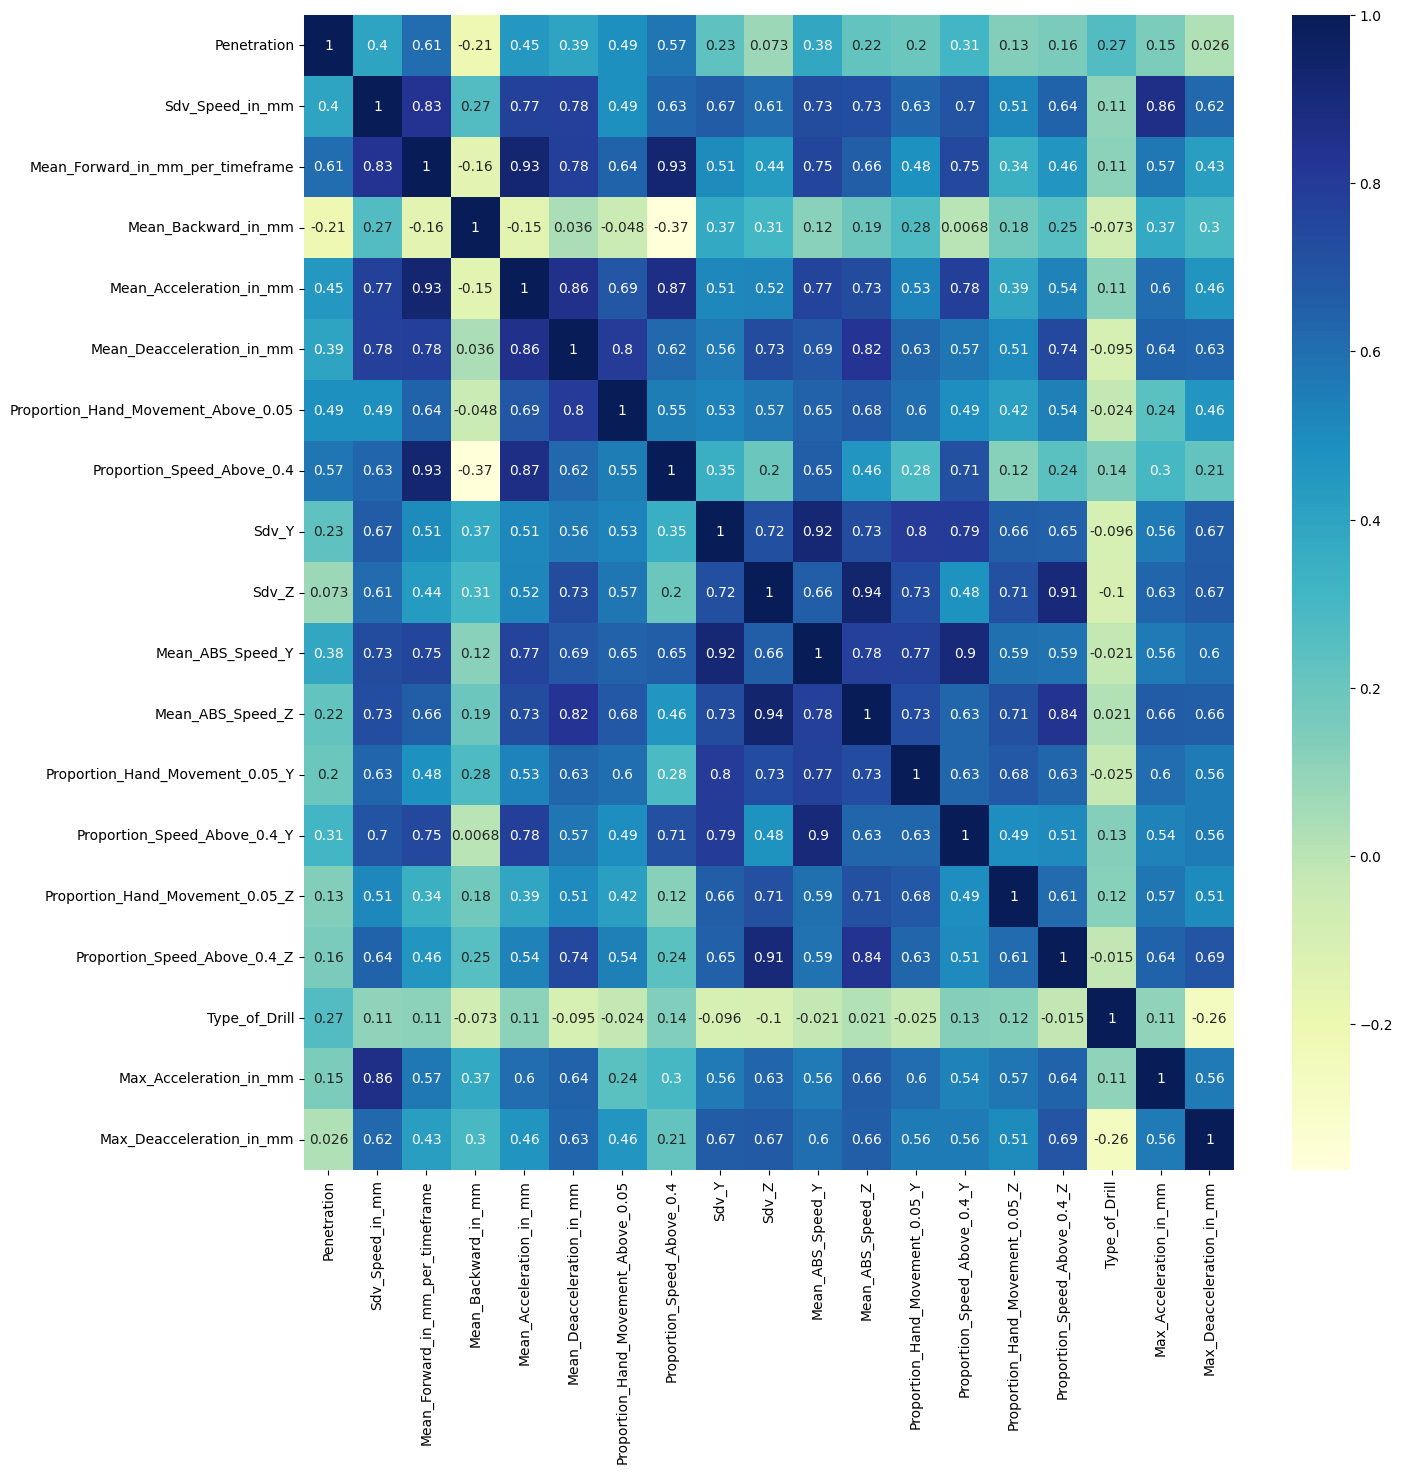

In [191]:
fig, ax = plt.subplots(figsize=(15,15))
dataplot = sns.heatmap(feature_df.corr(), cmap="YlGnBu", annot=True)

Text(0, 0.5, 'Counts')

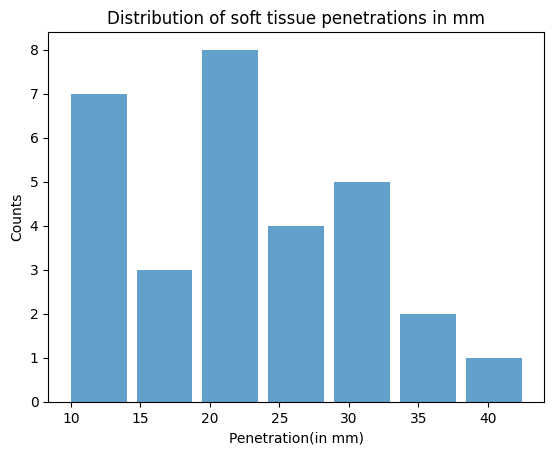

In [25]:
plt.hist(y,bins=7, alpha=0.7,rwidth=0.85)
plt.title('Distribution of soft tissue penetrations in mm')
plt.xlabel('Penetration(in mm)')
plt.ylabel('Counts')

#### Linear Models and GAMs

##### Linear Models

In [26]:
from sklearn.linear_model import Ridge
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X,y)

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso
from sklearn.ensemble import ExtraTreesRegressor

In [345]:
selector_untransformed = SelectKBest(r_regression, k=4)
selected_X_rreg = selector_untransformed.fit_transform(X, y)
selected_features = selector_untransformed.get_feature_names_out(feature_names)
print(selected_features)

lr = Ridge(alpha=.5)
scores_lr_MSE = cross_val_score(lr, selected_X_rreg , y, cv=30, scoring="neg_mean_squared_error")
scores_lr_MAE = cross_val_score(lr, selected_X_rreg , y, cv=30, scoring="neg_mean_absolute_error")

root_MSE_lr = math.sqrt(abs(scores_lr_MSE).mean())
print("The squared root of MSE is: " + str(root_MSE_lr))
print("The MAE is: " + str(abs(scores_lr_MAE.mean())))

from regressors import stats
lr.fit(selected_X_rreg, y)

stats.summary(lr, selected_X_rreg, y, selected_features)

['Mean_Forward_in_mm_per_timeframe' 'Mean_Acceleration_in_mm'
 'Proportion_Hand_Movement_Above_0.05' 'Proportion_Speed_Above_0.4']
The squared root of MSE is: 8.061539932317839
The MAE is: 6.672115279171611
Residuals:
    Min      1Q  Median     3Q     Max
-14.984 -6.8535  0.2769 5.4008 11.6048


Coefficients:
                                      Estimate  Std. Error  t value   p value
_intercept                           12.433537    9.150427   1.3588  0.184688
Mean_Forward_in_mm_per_timeframe     11.753251   59.811518   0.1965  0.845586
Mean_Acceleration_in_mm               4.406738   68.893278   0.0640  0.949437
Proportion_Hand_Movement_Above_0.05   9.469616   21.348188   0.4436  0.660639
Proportion_Speed_Above_0.4           13.556940   32.383565   0.4186  0.678566
---
R-squared:  0.28350,    Adjusted R-squared:  0.16886
F-statistic: 2.47 on 4 features


In [135]:
selector_transformed = SelectKBest(r_regression, k=6)
selected_X_rreg_transformed = selector_transformed.fit_transform(X_transformed, y)
selected_features_transformed = selector_transformed.get_feature_names_out(feature_names)
print(selected_features_transformed)

lr = Ridge(alpha=1)
scores_lr_MSE = cross_val_score(lr, selected_X_rreg_transformed , y, cv=30, scoring="neg_mean_squared_error")
scores_lr_MAE = cross_val_score(lr, selected_X_rreg_transformed , y, cv=30, scoring="neg_mean_absolute_error")

root_MSE_lr = math.sqrt(abs(scores_lr_MSE).mean())
print("The squared root of MSE is: " + str(root_MSE_lr))
print("The MAE is: " + str(abs(scores_lr_MAE.mean())))

from regressors import stats
lr.fit(selected_X_rreg_transformed, y)

stats.summary(lr, selected_X_rreg_transformed, y, selected_features_transformed)

['Sdv_Speed_in_mm' 'Mean_Forward_in_mm_per_timeframe'
 'Mean_Acceleration_in_mm' 'Mean_Deacceleration_in_mm'
 'Proportion_Hand_Movement_Above_0.05' 'Proportion_Speed_Above_0.4']
The squared root of MSE is: 7.354130386117593
The MAE is: 6.137039987389293
Residuals:
     Min      1Q  Median     3Q    Max
-15.5696 -4.7132   0.738 4.4221 9.9409


Coefficients:
                                      Estimate  Std. Error  t value   p value
_intercept                           22.198667    1.105415  20.0817  0.000000
Sdv_Speed_in_mm                      -0.800603    2.404189  -0.3330  0.741527
Mean_Forward_in_mm_per_timeframe      8.506743    6.138801   1.3857  0.176394
Mean_Acceleration_in_mm              -5.512025    3.593805  -1.5338  0.135928
Mean_Deacceleration_in_mm            -1.152096    2.937755  -0.3922  0.697801
Proportion_Hand_Movement_Above_0.05   3.082556    1.808337   1.7046  0.098955
Proportion_Speed_Above_0.4            1.414761    3.611739   0.3917  0.698135
---
R-squared:  0

In [337]:
sequentialSelector = SequentialFeatureSelector(Lasso(1), n_features_to_select=6)
selected_X_forward = sequentialSelector.fit_transform(X, y)
forward_selected_features = sequentialSelector.get_feature_names_out(feature_names)
print(forward_selected_features)

lr = Ridge(alpha=.5)
scores_lr_MSE = cross_val_score(lr, selected_X_forward , y, cv=10, scoring="neg_mean_squared_error")
scores_lr_MAE = cross_val_score(lr, selected_X_forward , y, cv=10, scoring="neg_mean_absolute_error")

root_MSE_lr = math.sqrt(abs(scores_lr_MSE).mean())
print("The squared root of MSE is: " + str(root_MSE_lr))
print("The MAE is: " + str(abs(scores_lr_MAE.mean())))

from regressors import stats
lr.fit(selected_X_forward, y)

stats.summary(lr, selected_X_forward, y, forward_selected_features)

['Sdv_Speed_in_mm' 'Mean_Forward_in_mm_per_timeframe'
 'Mean_Backward_in_mm' 'Mean_Acceleration_in_mm'
 'Mean_Deacceleration_in_mm' 'Proportion_Hand_Movement_Above_0.05']
The squared root of MSE is: 8.506808939802783
The MAE is: 7.027946904587006
Residuals:
    Min      1Q  Median     3Q     Max
-15.048 -7.0735  0.1795 5.3411 11.8483


Coefficients:
                                      Estimate  Std. Error  t value   p value
_intercept                           11.020723   10.223765   1.0780  0.289941
Sdv_Speed_in_mm                       6.448778   50.176230   0.1285  0.898623
Mean_Forward_in_mm_per_timeframe     13.750474   62.362680   0.2205  0.827033
Mean_Backward_in_mm                  -2.643822   75.442613  -0.0350  0.972285
Mean_Acceleration_in_mm               5.693947   80.461147   0.0708  0.944069
Mean_Deacceleration_in_mm             3.031526  107.728225   0.0281  0.977743
Proportion_Hand_Movement_Above_0.05  10.291397   26.956347   0.3818  0.705408
---
R-squared:  0.23501,

In [ ]:
sequentialSelector_transformed = SequentialFeatureSelector(Lasso(1), n_features_to_select=8)
selected_X_forward_transformed = sequentialSelector_transformed.fit_transform(X_transformed, y)
forward_selected_features_transformed = sequentialSelector_transformed.get_feature_names_out(feature_names)
print(forward_selected_features_transformed)

lr = Ridge(alpha=.5)
scores_lr_MSE = cross_val_score(lr, selected_X_forward_transformed , y, cv=10, scoring="neg_mean_squared_error")
scores_lr_MAE = cross_val_score(lr, selected_X_forward_transformed , y, cv=10, scoring="neg_mean_absolute_error")

root_MSE_lr = math.sqrt(abs(scores_lr_MSE).mean())
print("The squared root of MSE is: " + str(root_MSE_lr))
print("The MAE is: " + str(abs(scores_lr_MAE.mean())))

from regressors import stats
lr.fit(selected_X_forward_transformed, y)

stats.summary(lr, selected_X_forward_transformed, y, forward_selected_features_transformed)
#try 6 parameters

#### GAMs: try standardizing, transformation, outlier removal, and probably confounders

In [32]:
from pygam import LinearGAM, s, f, l, te
from sklearn.model_selection import KFold

##### Final model for report

In [338]:
forward_selected_features

array(['Sdv_Speed_in_mm', 'Mean_Forward_in_mm_per_timeframe',
       'Mean_Backward_in_mm', 'Mean_Acceleration_in_mm',
       'Mean_Deacceleration_in_mm', 'Proportion_Hand_Movement_Above_0.05'],
      dtype=object)

In [329]:
# 5 selected features by selectkbest
selected_features

array(['Sdv_Speed_in_mm', 'Mean_Forward_in_mm_per_timeframe',
       'Mean_Acceleration_in_mm', 'Mean_Deacceleration_in_mm',
       'Proportion_Hand_Movement_Above_0.05',
       'Proportion_Speed_Above_0.4'], dtype=object)

In [330]:
selected_features_np = ['Mean_Forward_in_mm_per_timeframe',
 'Mean_Backward_in_mm', 'Proportion_Hand_Movement_Above_0.05']
print(selected_features_np)
selected_features_kbest_type_drill = feature_df[selected_features_np ]
np_selected_type_drill_sqrt = np.sqrt(selected_features_kbest_type_drill.to_numpy())

['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm', 'Proportion_Hand_Movement_Above_0.05', 'Proportion_Hand_Movement_0.05_Y']


In [335]:
selected_features_kbest_type_drill

,Mean_Forward_in_mm_per_timeframe,Mean_Acceleration_in_mm,Proportion_Hand_Movement_Above_0.05,Proportion_Hand_Movement_0.05_Y
0,0.145269,0.126452,0.733813,0.721429
1,0.107080,0.086430,0.606498,0.630996
2,0.078892,0.078903,0.600000,0.570707
3,0.109905,0.083336,0.650000,0.627778
4,0.103024,0.093966,0.606061,0.620690
5,0.108327,0.077246,0.613861,0.643564
6,0.096728,0.087497,0.572864,0.610526
7,0.127863,0.096321,0.679104,0.679104
8,0.156520,0.080255,0.642276,0.696721
9,0.167723,0.097609,0.681529,0.727848


Text(0.02, 0.5, 'Count')

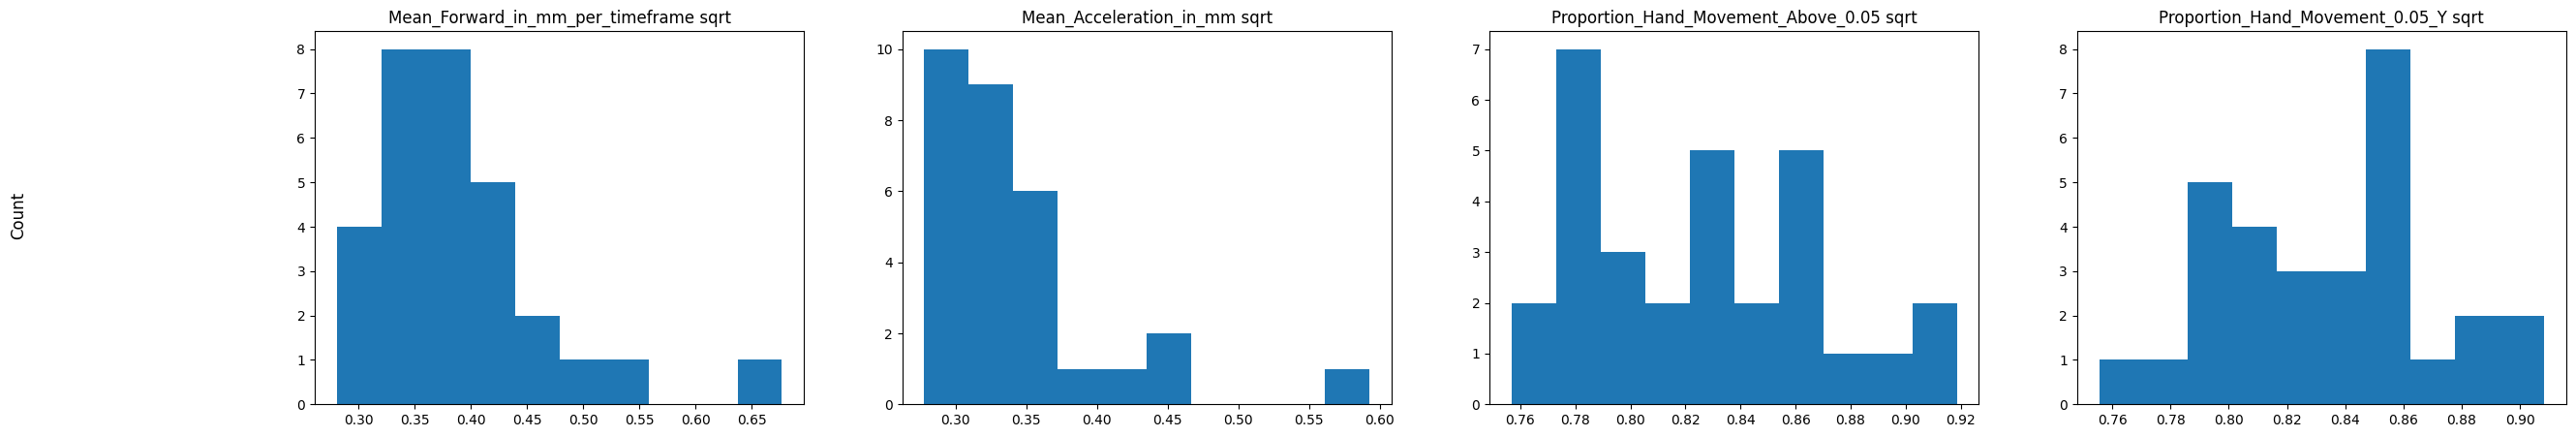

In [299]:
fig, axs = plt.subplots(1,len(selected_features_np), figsize=(30,5))
titles = selected_features_np
for i, ax in enumerate(axs):
    ax.hist(np_selected_type_drill_sqrt[:, i])
    ax.set_title(titles[i]+' sqrt')
fig.supylabel('Count')

Text(0.02, 0.5, 'response')

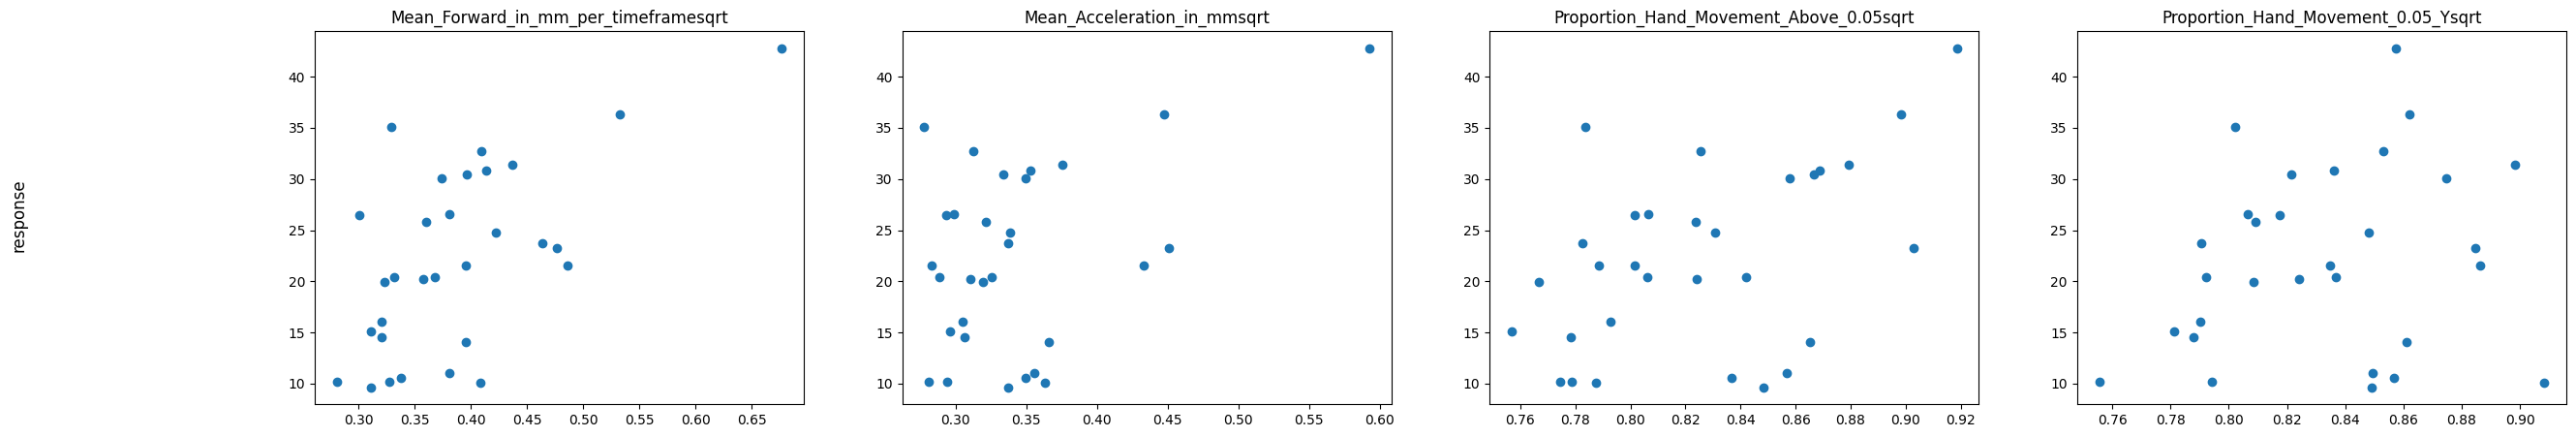

In [301]:
fig, axs = plt.subplots(1,len(selected_features_np), figsize=(30,5))
titles = selected_features_np
for i, ax in enumerate(axs):
    ax.scatter(np_selected_type_drill_sqrt[:, i],y)
    ax.set_title(titles[i] + 'sqrt')
fig.supylabel('response')

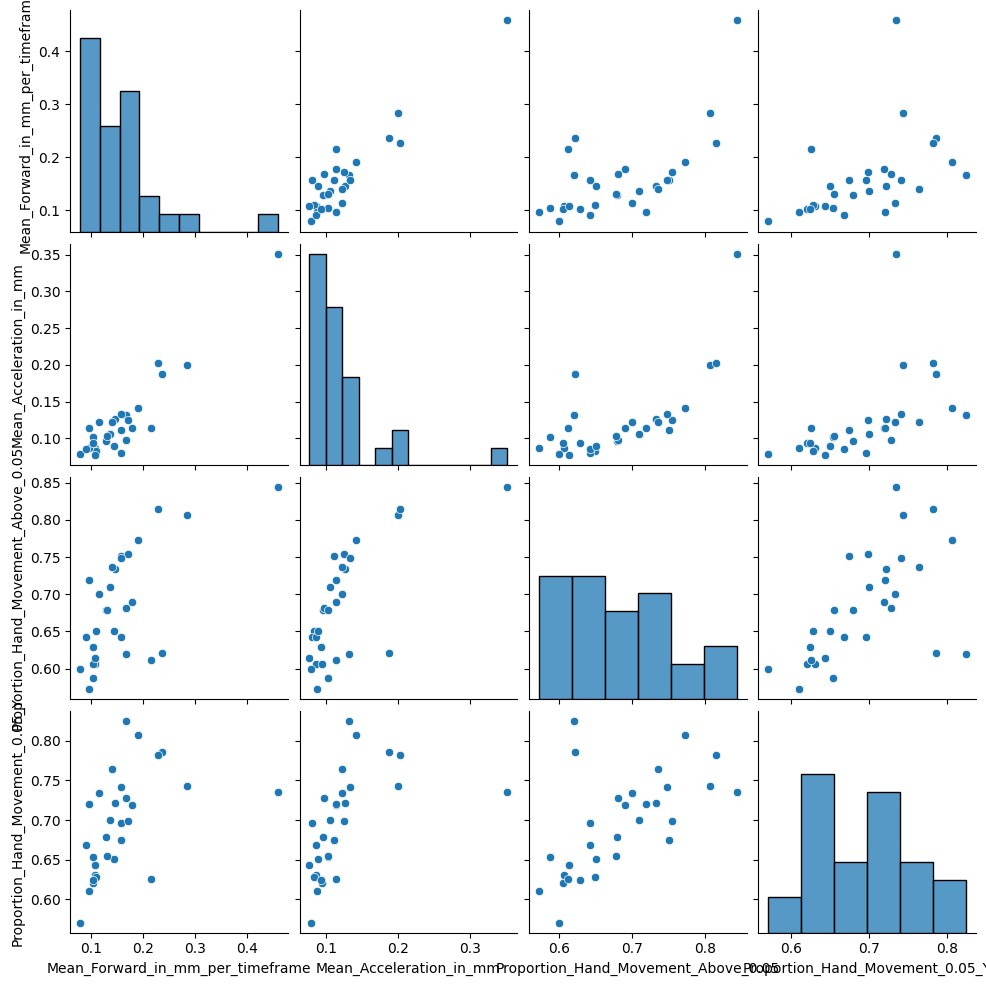

In [302]:
sns.pairplot(selected_features_kbest_type_drill)

In [35]:
selected_features_kbest_type_drill.to_csv("Selected_Features_For_GAM.csv",index=False)

In [319]:
gam_new = LinearGAM( s(0, n_splines=15) + s(1, n_splines=15)+  s(2, n_splines=15) + s(3, n_splines= 15) )
gam_new.fit(np_selected_type_drill_sqrt, y)
gam_new.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      6.1201
Link Function:                     IdentityLink Log Likelihood:                                  -149.6543
Number of Samples:                           30 AIC:                                              313.5488
                                                AICc:                                             318.8336
                                                GCV:                                               90.6646
                                                Scale:                                             58.1306
                                                Pseudo R-Squared:                                   0.4054
Feature Function                  Lam

C:\Users\liule\AppData\Local\Temp\ipykernel_2040\1904962666.py:3: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




Text(0.02, 0.5, 'Change in penetration')

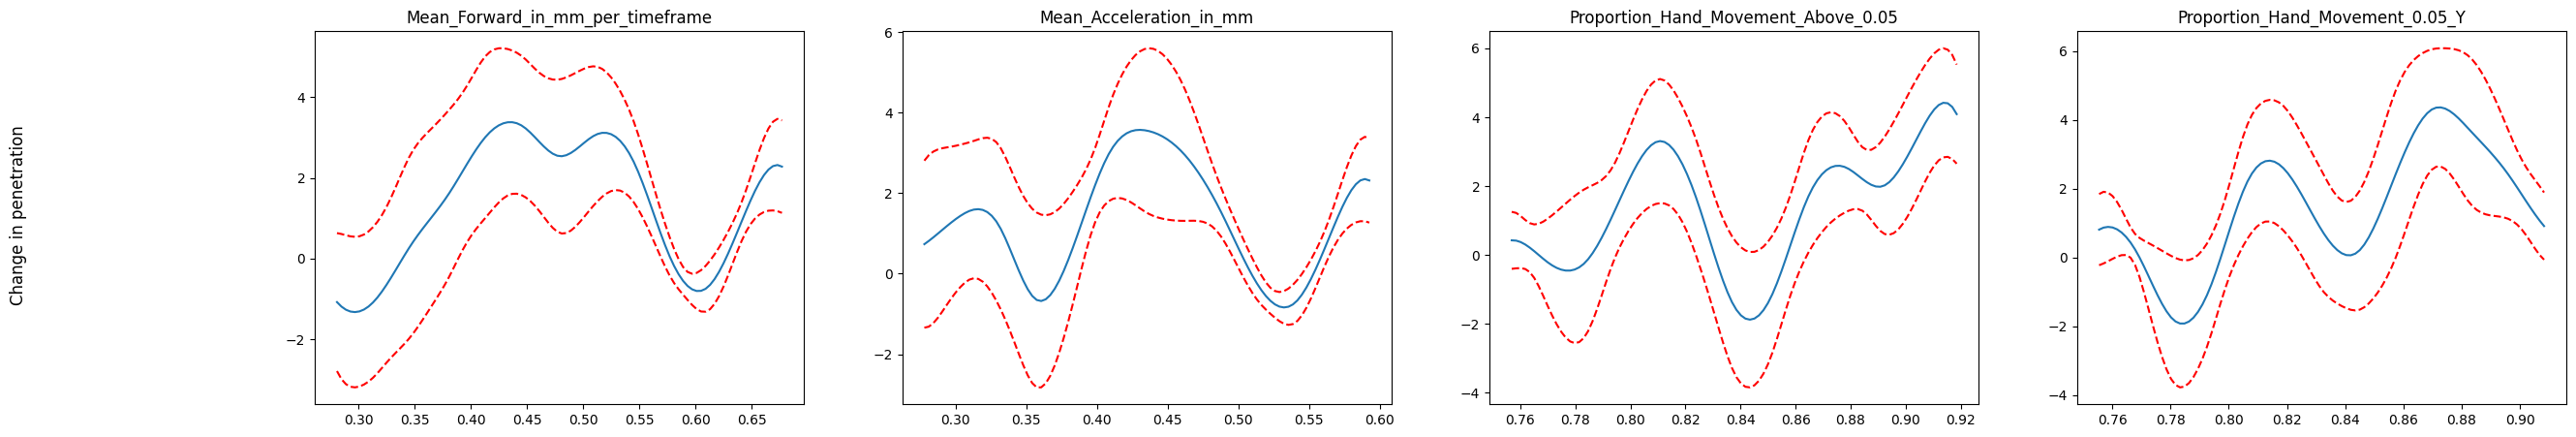

In [320]:
fig, axs = plt.subplots(1,4, figsize=(30,5))
titles = selected_features_np
for i, ax in enumerate(axs):
    XX = gam_new.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_new.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_new.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
fig.supylabel('Change in penetration')

In [321]:
kf = KFold(n_splits=30)
kf.get_n_splits(np_selected_type_drill_sqrt)
MAEs = []

for i, (train_index, test_index) in enumerate(kf.split(np_selected_type_drill_sqrt)):
    train_X = np_selected_type_drill_sqrt[train_index]
    train_y = y[train_index]
    test_X = np_selected_type_drill_sqrt[test_index]
    test_y = y[test_index]
    gam_new.fit(train_X, train_y)
    predictions = gam_new.predict(test_X)
    err = np.subtract(predictions, test_y)
    abs_err = np.absolute(err)
    MAEs.append(abs_err.mean())
print("MAE of leave-one-out corss validation is: " + str(statistics.mean(MAEs)) + " in mm")

MAE of leave-one-out corss validation is: 9.08773788485607 in mm


###### Model Validation

In [39]:
gam_new.fit(np_selected_type_drill, y)
res = gam_new.deviance_residuals(np_selected_type_drill, y)
prediction_list = gam_new.predict(np_selected_type_drill)

Text(0, 0.5, 'Counts')

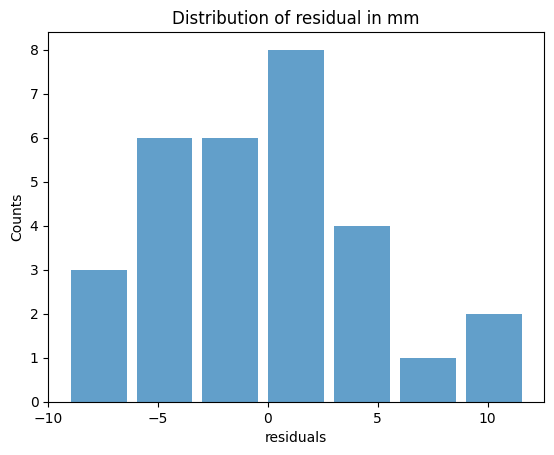

In [40]:
plt.hist(res,bins=7, alpha=0.7,rwidth=0.85)
plt.title('Distribution of residual in mm')
plt.xlabel('residuals')
plt.ylabel('Counts')

Text(0, 0.5, 'residuals')

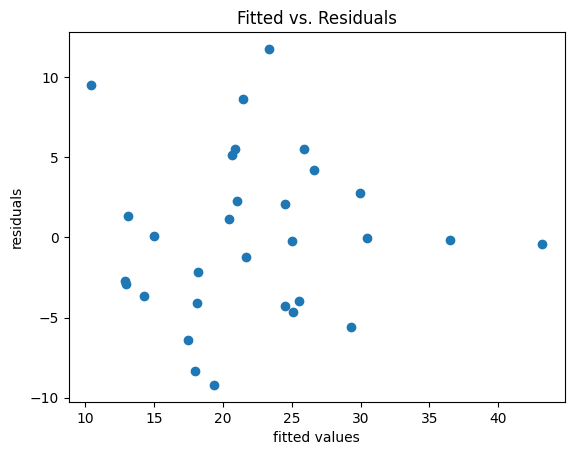

In [41]:
plt.scatter(y=res, x = prediction_list)
plt.title('Fitted vs. Residuals')
plt.xlabel('fitted values')
plt.ylabel('residuals')

Text(0, 0.5, 'response')

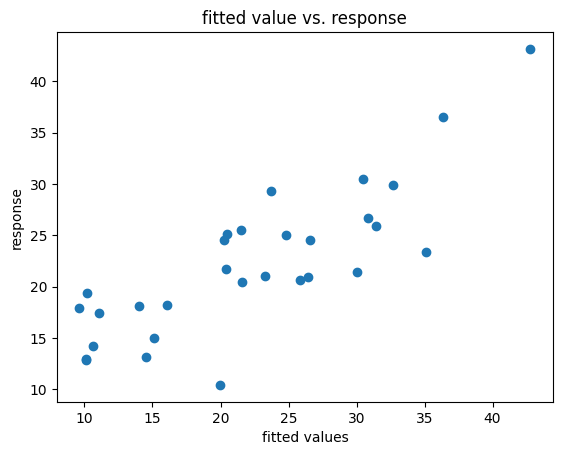

In [43]:
plt.scatter(y=prediction_list, x = y)
plt.title('fitted value vs. response')
plt.xlabel('fitted values')
plt.ylabel('response')

##### Older version GAM

In [45]:

#selected_features_np = np.append(selected_features, "Type_of_Drill")
print(selected_features)
selected_features_kbest = feature_df[selected_features]
selected_features_kbest.to_csv("selected_predictor.csv", index = False)


['Mean_Forward_in_mm_per_timeframe' 'Mean_Acceleration_in_mm'
 'Proportion_Hand_Movement_Above_0.05' 'Proportion_Speed_Above_0.4']


In [71]:
feature_df['Mean_Acceleration_in_mm']

0     0.126452
1     0.086430
2     0.078903
3     0.083336
4     0.093966
5     0.077246
6     0.087497
7     0.096321
8     0.080255
9     0.097609
10    0.131713
11    0.351270
12    0.113714
13    0.102183
14    0.086008
15    0.114466
16    0.093102
17    0.089171
18    0.106093
19    0.103322
20    0.111418
21    0.124684
22    0.140988
23    0.187440
24    0.113582
25    0.133691
26    0.122402
27    0.200225
28    0.203153
29    0.122008
Name: Mean_Acceleration_in_mm, dtype: float64

In [46]:
selected_features

array(['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm',
       'Proportion_Hand_Movement_Above_0.05',
       'Proportion_Speed_Above_0.4'], dtype=object)

In [47]:
y.to_csv("response.csv", index = False)

In [48]:
np_selected = selected_features_kbest.to_numpy()

In [327]:
gam = LinearGAM(s(0,penalties='derivative',n_splines=6) + s(1, n_splines=5) + s(2, n_splines=5)+ s(3,penalties='derivative',n_splines=5))
gam.fit(np_selected, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       5.718
Link Function:                     IdentityLink Log Likelihood:                                  -138.9299
Number of Samples:                           30 AIC:                                              291.2958
                                                AICc:                                             295.9498
                                                GCV:                                               61.0318
                                                Scale:                                             40.5312
                                                Pseudo R-Squared:                                   0.5785
Feature Function                  Lam

C:\Users\liule\AppData\Local\Temp\ipykernel_2040\3974370054.py:3: UserWarning:

KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 




Text(0.02, 0.5, 'Change in penetration')

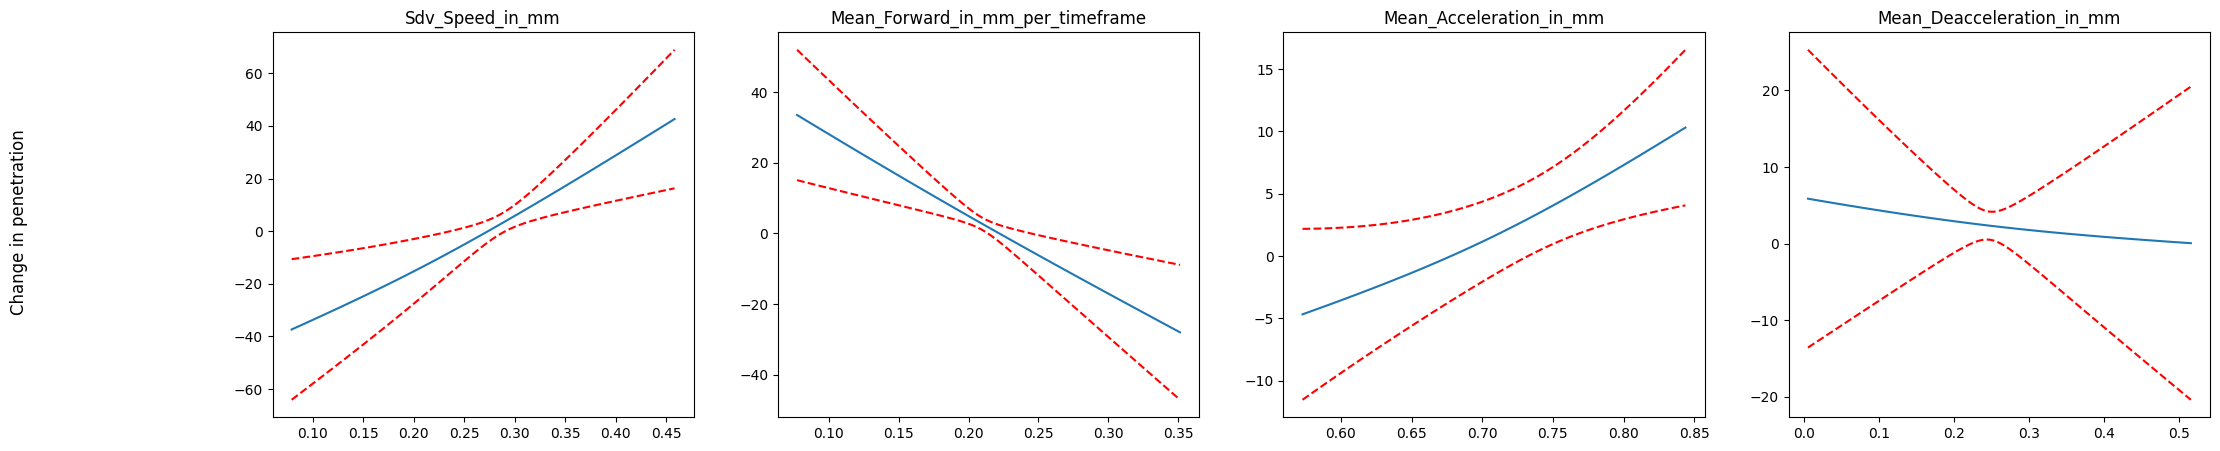

In [328]:
fig, axs = plt.subplots(1,4, figsize=(25,5))
titles = selected_features
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    ax.set_title(titles[i])
fig.supylabel('Change in penetration')

In [323]:
kf = KFold(n_splits=30)
kf.get_n_splits(np_selected)
MAEs = []
res = []
prediction_list = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    train_X = np_selected[train_index]
    train_y = y[train_index]
    test_X = np_selected[test_index]
    test_y = y[test_index]
    gam.fit(train_X, train_y)
    predictions = gam.predict(test_X)
    err = np.subtract(predictions, test_y)
    res = np.append(res, err)
    prediction_list = np.append(prediction_list, predictions)
    abs_err = np.absolute(err)
    MAEs.append(abs_err.mean())
print("MAE of leave-one-out corss validation is: " + str(statistics.mean(MAEs)) + " in mm")
    

MAE of leave-one-out corss validation is: 6.429557703675289 in mm


###### Model validation

In [258]:
gam.fit(np_selected, y)
res = gam.deviance_residuals(np_selected, y)
prediction_list = gam.predict(np_selected)

In [ ]:
plt.hist(res,bins=7, alpha=0.7,rwidth=0.85)
plt.title('Distribution of residual in mm')
plt.xlabel('residuals')
plt.ylabel('Counts')

In [ ]:
plt.scatter(y=res, x = prediction_list)
plt.title('fitted vs. residual')
plt.xlabel('fitted value')
plt.ylabel('residuals')

In [ ]:
plt.scatter(y=y, x = prediction_list)
plt.title('fitted vs. respsonse')
plt.xlabel('fitted value')
plt.ylabel('response')

#### Explainable Boosting

##### model and results

In [346]:
from sklearn.model_selection import train_test_split
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process.kernels import RBF

In [352]:
selected_features

array(['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm',
       'Proportion_Hand_Movement_Above_0.05',
       'Proportion_Speed_Above_0.4'], dtype=object)

In [347]:
ebm = ExplainableBoostingRegressor(learning_rate= 0.001, max_leaves=32, max_rounds= 10000, feature_names = selected_features, early_stopping_rounds= 200,
                                   interactions=0,validation_size=0.4,early_stopping_tolerance=0.001,inner_bags=16,outer_bags=8,binning="rounded_quantile",max_bins=512
                                   )

In [348]:
kernel_rbf = 0.9 * RBF(length_scale= 1.3)
krr = KernelRidge(alpha=1, kernel=kernel_rbf)

scores_ebm = cross_val_score(ebm, selected_X_rreg, y, cv=10, scoring="neg_mean_squared_error")
scores_ebm_abs = cross_val_score(ebm, selected_X_rreg, y, cv=10, scoring="neg_mean_absolute_error")

In [349]:
root_MSE = math.sqrt(abs(scores_ebm).mean())
print("The squared root of MSE is: " + str(root_MSE))
print("The MAE is: " + str(abs(scores_ebm_abs.mean())))

The squared root of MSE is: 8.922128454817406
The MAE is: 7.188044429206184


In [350]:
ebm.fit(selected_X_rreg, y)

ExplainableBoostingRegressor(binning='rounded_quantile',
                             early_stopping_rounds=200,
                             early_stopping_tolerance=0.001,
                             feature_names=array(['Mean_Forward_in_mm_per_timeframe', 'Mean_Acceleration_in_mm',
       'Proportion_Hand_Movement_Above_0.05',
       'Proportion_Speed_Above_0.4'], dtype=object),
                             inner_bags=16, interactions=0, learning_rate=0.001,
                             max_bins=512, max_leaves=32, max_rounds=10000,
                             validation_size=0.4)

In [351]:
show(ebm.explain_global(name="Soft_Penetration"))

<!-- http://127.0.0.1:7001/2323370366096/ -->

In [ ]:
show(ebm.explain_local(selected_X_forward, y), 0)

##### model-agnostic

In [277]:
from interpret.blackbox import ShapKernel

In [ ]:
shap = ShapKernel(ebm, X, feature_names=feature_names)

In [ ]:
show(shap.explain_local(X, y), 0)

#### Ensemble model

In [79]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

import lightgbm as lgbm

In [81]:
scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)
estimators = []
kernel_rbf = 0.9 * RBF(length_scale= 0.1, length_scale_bounds=(1e-06, 0.5))
krr = KernelRidge(alpha= 0.5, kernel=kernel_rbf)
estimators.append(('krr',krr))

lgbm_regressor = lgbm.LGBMRegressor(learning_rate= 0.03, n_estimators=200, reg_alpha= 0.1, reg_lambda=0.1)
estimators.append(('lgbm', lgbm_regressor))

adaboost = AdaBoostRegressor(learning_rate= 0.03, n_estimators= 200, loss='exponential')
estimators.append(('adaboost', adaboost))

gradientboost = GradientBoostingRegressor(learning_rate=0.03)
estimators.append(('gradientboost',gradientboost))

gpr = GaussianProcessRegressor(kernel=kernel_rbf,normalize_y=True,n_restarts_optimizer=3)
estimators.append(('gpr',gpr))

stack = StackingRegressor(estimators=estimators, final_estimator= Ridge(alpha=0.3))
scores_stack = cross_val_score(stack, X_transformed , y, cv=10, scoring="neg_mean_absolute_error")
scores_stack_MSE = cross_val_score(stack, X_transformed , y, cv=10, scoring="neg_mean_squared_error")

In [82]:
sqrt_MSE = math.sqrt(abs(scores_stack_MSE.mean()))
print("The squared root of MSE is: " + str(sqrt_MSE))
print("The MAE is: " + str(abs(scores_stack.mean())))

The squared root of MSE is: 8.92743855726987
The MAE is: 7.551680710797315


#### Try to build models separately with EBM and Stacking

##### EBM

In [197]:
one_bone_drill_feature_df = feature_df[feature_df.index % 3 != 2]
cross_bone_drill_feature_df = feature_df[feature_df.index % 3 == 2]

In [198]:
X_one_bone = one_bone_drill_feature_df.iloc[:, 1:]
y_one_bone = one_bone_drill_feature_df.iloc[:, 0]
scaler = StandardScaler()
#X_one_bone = scaler.fit_transform(X_one_bone)
seed = 42
np.random.seed(seed)

X_cross_bone = cross_bone_drill_feature_df.iloc[:, 1:]
y_cross_bone = cross_bone_drill_feature_df.iloc[:, 0]
scaler = StandardScaler()
#X_cross_bone = scaler.fit_transform(X_cross_bone)
seed = 42
np.random.seed(seed)

In [199]:
ebm_one = ExplainableBoostingRegressor(learning_rate= 0.003, max_leaves=8, max_rounds= 5000, feature_names = feature_names, inner_bags= 8, outer_bags= 16, early_stopping_rounds= 50)

ebm_cross = ExplainableBoostingRegressor(learning_rate= 0.003, max_leaves=8, max_rounds= 5000, feature_names = feature_names, inner_bags= 8, outer_bags= 16, early_stopping_rounds= 50)

scores_ebm_mse_one = cross_val_score(ebm_one, X_one_bone, y_one_bone, cv=10, scoring="neg_mean_squared_error")
scores_ebm_abs_one = cross_val_score(ebm_one, X_one_bone, y_one_bone, cv=10, scoring="neg_mean_absolute_error")

scores_ebm_mse_cross = cross_val_score(ebm_cross, X_cross_bone, y_cross_bone, cv=10, scoring="neg_mean_squared_error")
scores_ebm_abs_cross = cross_val_score(ebm_cross, X_cross_bone, y_cross_bone, cv=10, scoring="neg_mean_absolute_error")

In [200]:
root_MSE_one = math.sqrt(abs(scores_ebm_mse_one).mean())
print("The squared root of MSE of EBM for one bone is: " + str(root_MSE_one))
print("The MAE of EBM for one bone is: " + str(abs(scores_ebm_abs_one.mean())))

root_MSE_cross = math.sqrt(abs(scores_ebm_mse_cross).mean())
print("The squared root of MSE of EBM for cross bone is: " + str(root_MSE_cross))
print("The MAE of EBM for cross bone is: " + str(abs(scores_ebm_abs_cross.mean())))

The squared root of MSE of EBM for one bone is: 9.120202511725424
The MAE of EBM for one bone is: 7.564843066750254
The squared root of MSE of EBM for cross bone is: 11.373412427018009
The MAE of EBM for cross bone is: 9.602385002994396


In [ ]:
ebm_one.fit(X_one_bone, y_one_bone)
show(ebm_one.explain_global())

In [ ]:
ebm_cross.fit(X_cross_bone, y_cross_bone)
show(ebm_cross.explain_global())

##### Stacking

In [203]:
scores_stack_one = cross_val_score(stack, X_one_bone, y_one_bone, cv=10, scoring="neg_mean_absolute_error")
scores_stack_MSE_one = cross_val_score(stack, X_one_bone, y_one_bone, cv=10, scoring="neg_mean_squared_error")

The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 0.5. Increasing the bound and calling fit again may find a better value.


In [204]:
print("MAE for one bone stack: " + str(abs(scores_stack_one.mean())))
print("Root MSE for one bone stack: " + str(math.sqrt(abs(scores_stack_MSE_one.mean()))))

MAE for one bone stack: 7.093712572870956
Root MSE for one bone stack: 8.588211420605123


### Anomality Detection (more based on features extracted and trajectories)

#### One-class SVM

In [70]:
from sklearn.svm import OneClassSVM

In [71]:
one_class_svm = OneClassSVM(nu=0.1)

In [72]:
np_log_transofmred = np.log(selected_features_kbest_type_drill.to_numpy())

In [73]:
anomaly_train, anomaly_test = train_test_split(selected_features_kbest_type_drill,test_size=0.2)

In [74]:
one_class_svm.fit(anomaly_train)

OneClassSVM(nu=0.1)

In [75]:
anomaly_test

,Sdv_Speed_in_mm,Mean_Forward_in_mm_per_timeframe,Mean_Acceleration_in_mm,Proportion_Hand_Movement_Above_0.05
26,0.138993,0.114264,0.122402,0.700000
25,0.211261,0.156748,0.133691,0.748503
5,0.109347,0.108327,0.077246,0.613861
29,0.156904,0.139612,0.122008,0.736059
15,0.210277,0.178429,0.114466,0.690058
0,0.193525,0.145269,0.126452,0.733813


In [76]:
one_class_svm.predict(anomaly_test)

array([1, 1, 1, 1, 1, 1], dtype=int64)

### Counterfactual Analysis -- providing insights on "how to do better"